In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
seed = 7
scoring = 'neg_mean_squared_error'

pisa = pd.read_csv('pisa2009.csv')
y = pisa['readingScore']
pisa = pisa.drop('readingScore', axis=1)

# Missing values
# For continuous variables replace the missing data with average of columns
pisa['minutesPerWeekEnglish'].fillna(int(pisa['minutesPerWeekEnglish'].mean()), inplace=True)
pisa['studentsInEnglish'].fillna(int(pisa['studentsInEnglish'].mean()), inplace=True)
pisa['schoolSize'].fillna(int(pisa['schoolSize'].mean()), inplace=True)

# For 'raceeth' use 'missing' replacement
pisa['raceeth'].fillna('NoRace', inplace=True)
# For binary variable use 0.5 in place of missing value

pisa = pisa.apply(lambda x:x.fillna(0.5))

# Encode categorical data
raceeth = pd.get_dummies(pisa['raceeth'], 'raceeth')
pisa = pd.concat([pisa, raceeth], axis=1)
pisa = pisa.drop('raceeth', axis=1)

# remove multicolinearity
pisa = pisa.drop(['motherBachelors','motherBornUS', 'fatherBornUS'], axis=1)

# reduce skewness
pisa['schoolSize'] = np.log1p(pisa['schoolSize'])
pisa['minutesPerWeekEnglish'] = np.sqrt(pisa['minutesPerWeekEnglish'])

X = pisa.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)


In [3]:

# Cross validation framework

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor

def do_cross_validation(X, y, scoring = 'neg_mean_squared_error'):
    models = []
    models.append(('LR', LinearRegression()))
    models.append(('LASSO', Lasso()))
    models.append(('ElasticNet', ElasticNet()))
    models.append(('Bayesian Ridge', BayesianRidge()))
    models.append(('Ridge', Ridge()))
    models.append(('KNN', KNeighborsRegressor()))
    models.append(('DecisionTree', DecisionTreeRegressor()))
    models.append(('SupprtVector', SVR()))
    models.append(('AdaBoost', AdaBoostRegressor() ))
    models.append(('GradientBoost', GradientBoostingRegressor() ))
    models.append(('RandomForests', RandomForestRegressor() ))
    models.append(('ExtraTrees', ExtraTreesRegressor()))
    
    results_rmse = []
    results_r2 = []
    names = []
    for name, model in models:
        kfold = KFold(n_splits=10, random_state=7)
        cv_results = np.sqrt(-cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring))
        cv_results_r2 = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2')
        results_rmse.append(cv_results)
        results_r2.append(cv_results_r2)
        names.append(name)
        msg = "%7s: %.3f (%.3f) r2: %.3f (%.3f)" % \
        (name, cv_results.mean(), cv_results.std(), cv_results_r2.mean(), cv_results_r2.std())
        print(msg)
    return results_rmse, results_r2, names

In [4]:
rmse, r2, names = do_cross_validation(X_train, y_train)


     LR: 77.536 (2.120) r2: 0.343 (0.037)
  LASSO: 78.236 (2.076) r2: 0.331 (0.031)
ElasticNet: 85.032 (2.588) r2: 0.211 (0.014)
Bayesian Ridge: 77.518 (2.107) r2: 0.343 (0.036)
  Ridge: 77.533 (2.118) r2: 0.343 (0.037)
    KNN: 87.281 (2.692) r2: 0.166 (0.060)
DecisionTree: 109.253 (4.081) r2: -0.306 (0.128)
SupprtVector: 89.980 (3.071) r2: 0.116 (0.010)
AdaBoost: 79.417 (2.496) r2: 0.310 (0.027)
GradientBoost: 74.321 (2.147) r2: 0.396 (0.038)
RandomForests: 81.251 (2.884) r2: 0.256 (0.050)
ExtraTrees: 87.654 (3.740) r2: 0.169 (0.069)


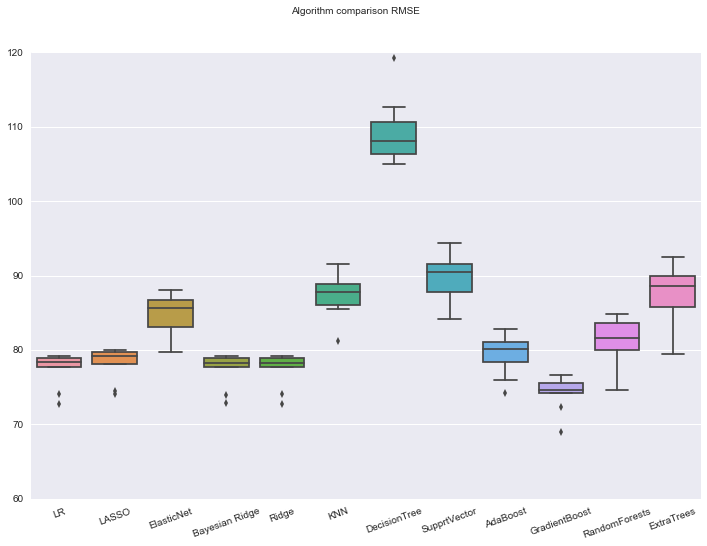

In [5]:
# Compare Algorithms
fig = plt.figure(figsize=(12, 8))
fig.suptitle('Algorithm comparison RMSE')
ax = fig.add_subplot(111)
sns.boxplot(y = rmse, x= names)
#ax.set_xticklabels(names)
a = plt.xticks(rotation = 20)
plt.show()

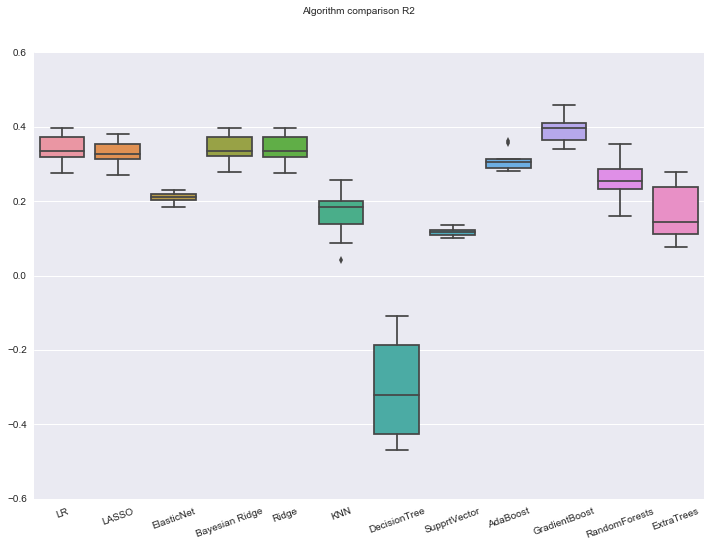

In [6]:
# Compare Algorithms
fig = plt.figure(figsize=(12, 8))
fig.suptitle('Algorithm comparison R2')
ax = fig.add_subplot(111)
sns.boxplot(y = r2, x= names)
#ax.set_xticklabels(names)
a = plt.xticks(rotation = 20)
plt.show()

In [7]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
model = GradientBoostingRegressor()
model.fit(X_train, y_train)
prediction = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, prediction))
r2 = r2_score(y_test, prediction)

# base line scores
baseline_pred = np.empty(y_test.shape[0])
baseline_pred.fill(np.mean(y_test))

baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
baseline_r2 = r2_score(y_test, baseline_pred)

print('test set rmse: %.2f is better compared to baseline %.2f' % (rmse, baseline_rmse))
print('test set r2: %.2f is better than baseline %.2f' % (r2, baseline_r2))


test set rmse: 72.16 is better compared to baseline 94.41
test set r2: 0.42 is better than baseline 0.00


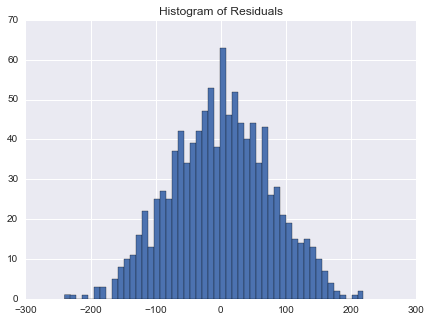

In [8]:
lr = LinearRegression()
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)
f = plt.figure(figsize=(7,5))
ax = f.add_subplot(111)
ax.hist(y_test - predictions, bins=50)
ax.set_title("Histogram of Residuals")

((array([-3.21080761, -2.94660583, -2.79923536, ...,  2.79923536,
          2.94660583,  3.21080761]),
  array([-240.07654436, -223.19381855, -205.15495391, ...,  203.60017369,
          218.67242717,  219.25642751])),
 (75.646554736228865, 0.3469734396251245, 0.99934715235374894))

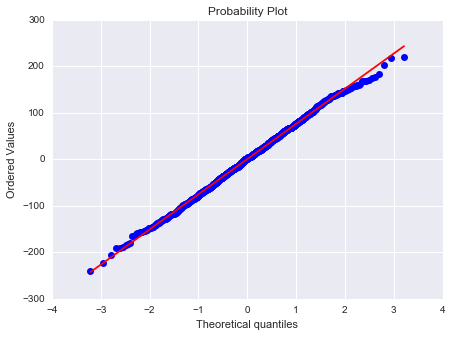

In [9]:
from scipy.stats import probplot
f = plt.figure(figsize=(7, 5))
ax = f.add_subplot(111)
probplot(y_test - predictions, plot=ax)